
### Author - Niraj Dev Pandey

`pandey@uni-hildesheim.de`

## Content
        * checking stationarity in the time-series
        * if it doesn't have stationarity property, make it stationary by using rolling mean
        * Arima forcasting by using AIC to find best parameter 
        * MSE and MAPE loss analization

Let's Start with the timeseries `daily_temperature` and later we will move to second timeseries called `Airpassenger`

In [179]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [186]:
series = Series.from_csv('daily_temperature.csv', header=0 )

In [187]:
series.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: temperature, dtype: float64

In [182]:
# series=series.astype(float)

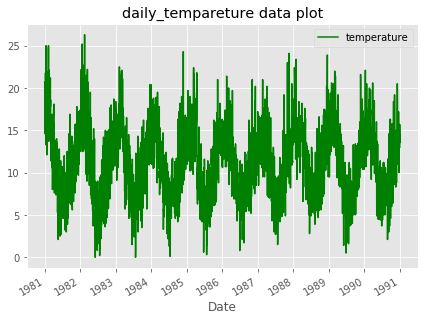

In [188]:
series.plot(figsize=(7,5), title = 'daily_tempareture data plot',color='g')
plt.legend(loc = "lower right")
plt.style.use('ggplot')
plt.legend(loc='best')

plt.show()

In [195]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.style.use('ggplot')
    plt.figure(figsize=(10,5))
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('temperature', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show()

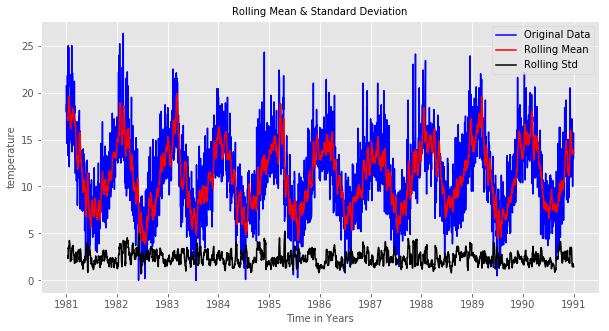

In [196]:
TestStationaryPlot(series)

In [131]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [78]:
TestStationaryAdfuller(series)

Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
Critical Value (1%)              -3.432153
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


Since it is already stationary we don't need to apply moving average here.

### Let's check for the second time-series

In [197]:
second_series = Series.from_csv('AirPassengers.csv',header = 0)

In [198]:
second_series.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

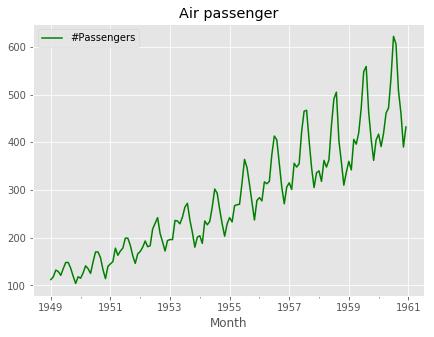

In [199]:
second_series.plot(figsize=(7,5), title = 'Air passenger',color='g')
plt.legend(loc = "lower right")
plt.style.use('ggplot')
plt.legend(loc='best')

plt.show()

In [176]:
TestStationaryAdfuller(second_series)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
Critical Value (1%)             -3.481682
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Let's see if moving average can help us to make this time-series stationary

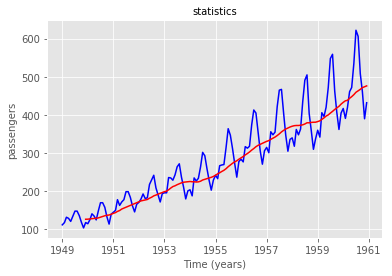

In [166]:
moving_avg = second_series.rolling(12).mean()
plt.plot(second_series,color='b')
plt.plot(moving_avg, color='r')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('passengers', fontsize = 10)
plt.title('statistics', fontsize = 10)
plt.show()

In [168]:
mte_moving_avg_diff = second_series - moving_avg
mte_moving_avg_diff.head(13)

Month
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01          NaN
1949-08-01          NaN
1949-09-01          NaN
1949-10-01          NaN
1949-11-01          NaN
1949-12-01    -8.666667
1950-01-01   -11.916667
Name: #Passengers, dtype: float64

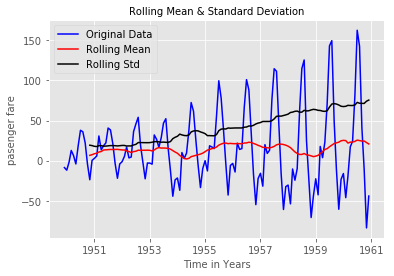

In [169]:
mte_moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(mte_moving_avg_diff)

In [170]:
TestStationaryAdfuller(mte_moving_avg_diff)

Test Statistic                  -3.164968
p-value                          0.022104
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
Critical Value (1%)             -3.486535
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


##### moving average doesn't help us to make it stationary

## Exercise 1(b)

### Arima Model 

In [88]:
first_series = read_csv('AirPassengers.csv' )

In [103]:
import warnings
import itertools
warnings.filterwarnings("ignore")
import statsmodels.api as sm

1. p is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
2. d is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
3. q is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

In [89]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


While in this case it is clear that s=12, how do we set the other parameters?

It is pretty much based on experience. There are numerous best practices that can be followed to identify ARIMA models, such as: http://people.duke.edu/~rnau/arimrule.htm.

In [92]:
first_series['Month']=pd.to_datetime(first_series['Month'], format='%Y-%m-%d')
first_series.set_index(['Month'], inplace=True)

train_data = first_series['1949-01-01':'1959-12-01']
test_data = first_series['1960-01-01':'1960-12-01']

`AIC` (Akaike Information Criterion) and `BIC` (Bayes Information Criterion) that can be minimized to select the best fitting model. We use the AIC value, which estimates the information lost when a given model is used to represent the process that generates the data. In doing so, it deals with the trade-off between the goodness of fit of the model and the complexity of the model itself.

In [104]:
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [106]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC),
                                                             SARIMAX_model[AIC.index(min(AIC))][0],
                                                             SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 618.2055123092972 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [107]:
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

Let's use the digmostic plot to see more statistics. Such as, 

In the plots below, one can observe that the residuals are uncorrelated (bottom right plot) and do not exhibit any obvious seasonality (the top left plot). Also, the residuals and roughly normally distributed with zero mean (top right plot). The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) roghly follows the linear trend of samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

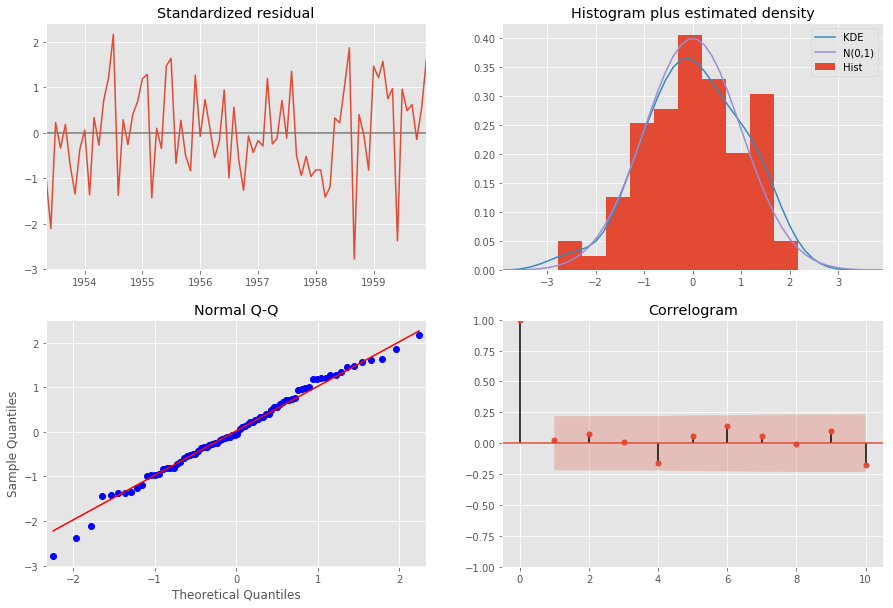

In [118]:
plt.style.use('ggplot')
results.plot_diagnostics(figsize=(15, 10))
plt.show()

Here model is learning from the date given below and then predicting values for the newly/never seen. 

In [110]:
pred0 = results.get_prediction(start='1958-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

pred1 = results.get_prediction(start='1958-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['1960-01-01':'1960-12-01'])

Looking at the figure below, the model seems to do a pretty good job at modeling the time series. The blue and purple lines are, as expected, very close to the red ground truth. What is more interesting is the gray line, the out of sample prediction. The ARIMA model has been able to forecast the 1960 values accurately.

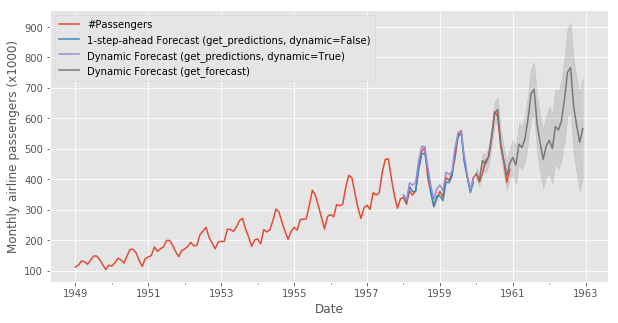

In [120]:
plt.style.use('ggplot')
ax = first_series.plot(figsize=(10, 5))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [150]:
prediction = pred2.predicted_mean['1960-01-01':'1960-12-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 1960 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of year 1960 is 2.81%


In [151]:
from sklearn.metrics import mean_squared_error
MSE_error = mean_squared_error(truth, prediction)
print('Test MSE: %.3f' % MSE_error)

Test MSE: 295.394


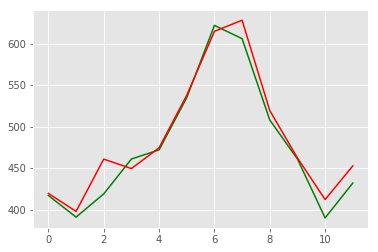

In [152]:
plt.plot(truth,color='g')
plt.plot(prediction, color='red')
plt.show()